# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Ejercicios a resolver](#tarea)

**EQUIPO 48**:

* José Alberto Rodríguez Sotomayor A01796604
* André Maximiliano Hernández Bien - A01795190
* César Armando Prieto Siller - A01796382
* Hector Magaña Torres A00823440




## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


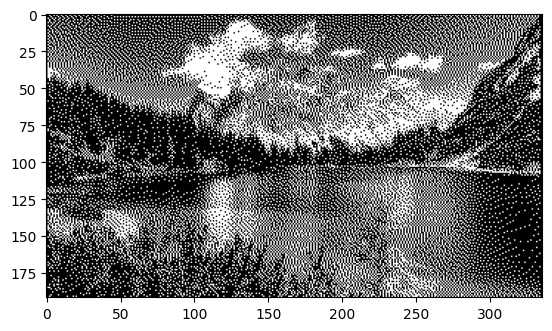

In [6]:
image = Image.open('/content/drive/MyDrive/Equipo 48/Imagenes Convolucion/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [7]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

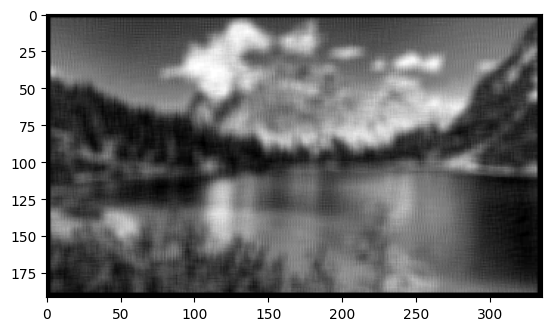

In [8]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [9]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/Equipo 48/Imagenes Convolucion/image.jpg')
img.thumbnail((256,256), Image.LANCZOS) # Resize to half to reduce the size of this notebook.

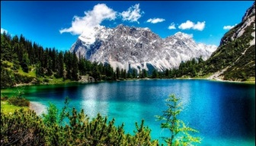

In [10]:
img

In [11]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [12]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [13]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

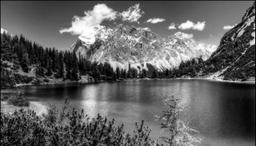

In [14]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [15]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [16]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.1209, -0.2545, -0.3253,  ..., -0.4225, -0.3486, -0.1853],
         [-0.0784, -0.2690, -0.3599,  ..., -0.4257, -0.3660, -0.1905],
         [-0.0730, -0.2667, -0.3706,  ..., -0.4233, -0.3045, -0.1792],
         ...,
         [-0.0104, -0.0579, -0.1188,  ..., -0.3878, -0.3966, -0.2846],
         [-0.0444, -0.0913, -0.1627,  ..., -0.4128, -0.4178, -0.3034],
         [ 0.0522, -0.0063, -0.0607,  ..., -0.0773, -0.1531, -0.1570]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [17]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [18]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [19]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [20]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

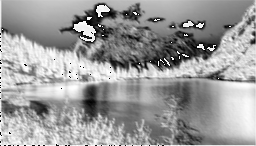

In [21]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

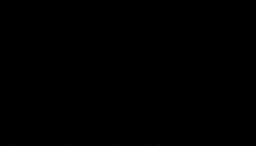

In [22]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [23]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

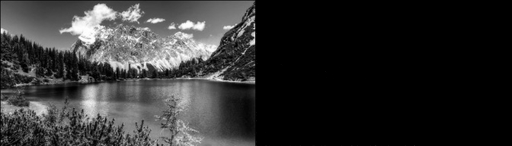

In [24]:
display(input, output)

### Identity

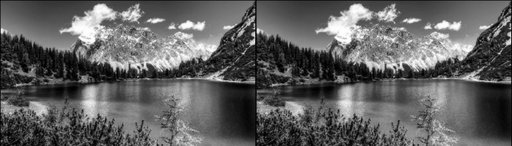

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


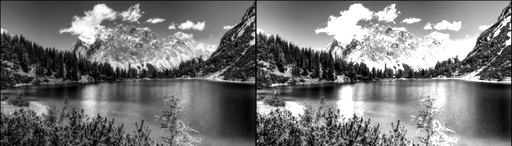

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


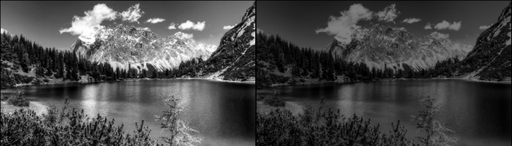

In [27]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


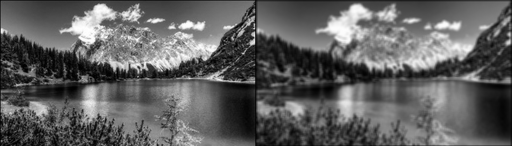

In [28]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


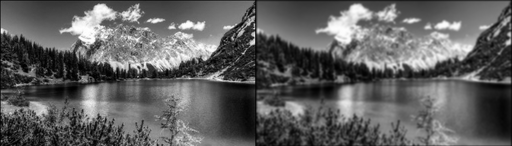

In [29]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


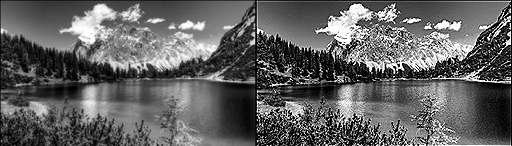

In [30]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


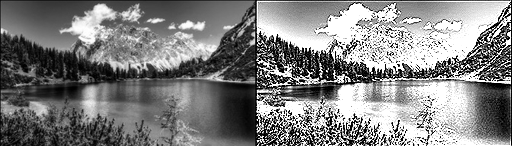

In [31]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


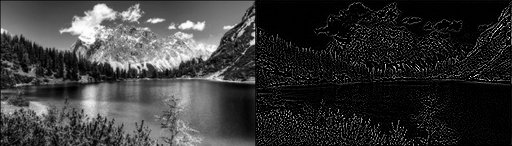

In [32]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

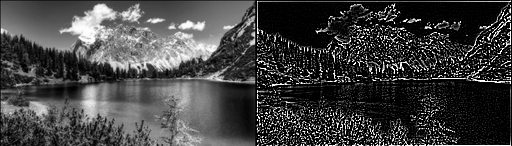

In [33]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

In [34]:
# TODO: Challenge, hard image with hard transformations

<a name="tarea"></a>

# Ejercicios a resolver

## Tabla de contenidos
1. [Detectores de línea](#linea)
2. [Algoritmos de realce o mejoramiento](#realce)
3. [Aplicación médica](#medica)

### Importar Librerias

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

import os

# Cambiar directorio de trabajo
os.chdir('/content/drive/MyDrive/Equipo 48')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cargar Imagenes en numpy

In [36]:
imagen_parque = Image.open('/content/drive/MyDrive/Equipo 48/Imagenes Convolucion/FujiQHighlands.jpg')
imagen_parque_bn = imagen_parque.convert('L') # convert image to black and white
imagen_parque_areglo = np.array(imagen_parque_bn)

imagen_pet = Image.open('/content/drive/MyDrive/Equipo 48/Imagenes Convolucion/PET2_libro.jpg')
imagen_pet_bn = imagen_pet.convert('L') # convert image to black and white
imagen_pet_areglo = np.array(imagen_pet_bn)

### Definir funcion para mostrar dos imagenes

In [37]:
def mostrar_imagenes(original,procesada, texto_procesada):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Imagen original
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')

    # Imagen procesada
    axes[1].imshow(procesada, cmap='gray')
    axes[1].set_title(texto_procesada)
    axes[1].axis('off')

    plt.suptitle('Imagenes Comparadas')
    plt.tight_layout()
    plt.show()


<a name="linea"></a>

## 1.- Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente? <a class="anchor" id="detectores-linea" ></a>

### Definir función de convolución

In [38]:
def convolucion(imagen, filtro):
  altura,ancho = imagen.shape
  dim_filtro = filtro.shape[0]
  padding = dim_filtro//2
  imagen_salida = np.zeros_like(imagen)
  imagen_entrada_con_padding = np.pad(imagen, dim_filtro, 'constant')

  for y in range(altura):
    for x in range(ancho):
      region_filtro_en_imagen = imagen_entrada_con_padding[y:y+dim_filtro,x:x+dim_filtro]
      valor_salida = np.sum(region_filtro_en_imagen*filtro)

      imagen_salida[y,x] = valor_salida


  return imagen_salida



### Aplicar Prewitt

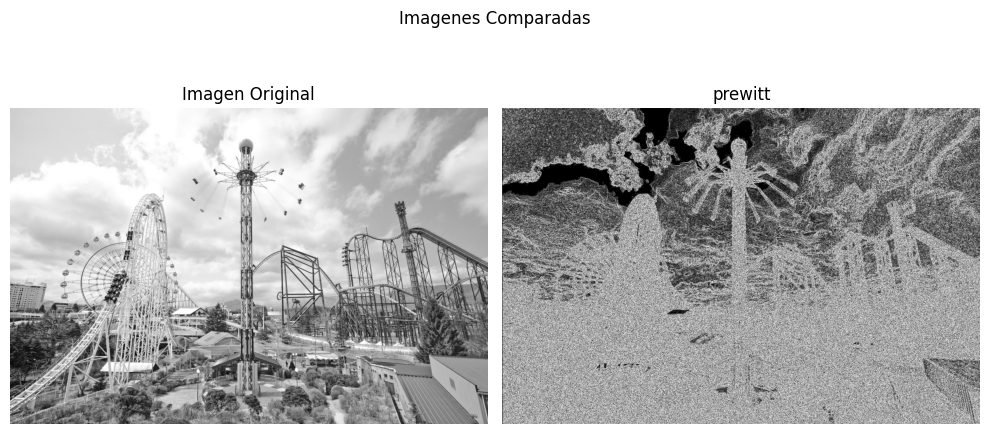

In [39]:
# Kernels de Prewitt para las direcciones X y Y
def prewitt(imagen):
  prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=float)

  prewitt_y = np.array([[-1, -1, -1],
                      [ 0,  0,  0],
                      [ 1,  1,  1]], dtype=float)

  # Convolución con ambos kernels
  gradiente_x = convolucion(imagen, prewitt_x)
  gradiente_y = convolucion(imagen, prewitt_y)

  # Calcular la magnitud del gradiente
  prewitt_imagen_salida = np.sqrt(gradiente_x**2 + gradiente_y**2)

  # Normalizar para que la imagen de salida sea visible
  mostrar_imagenes(imagen,prewitt_imagen_salida,"prewitt")

  return prewitt_imagen_salida



prewitt_imagen_parque_salida = prewitt(imagen_parque_areglo)






### Aplicar Sobel

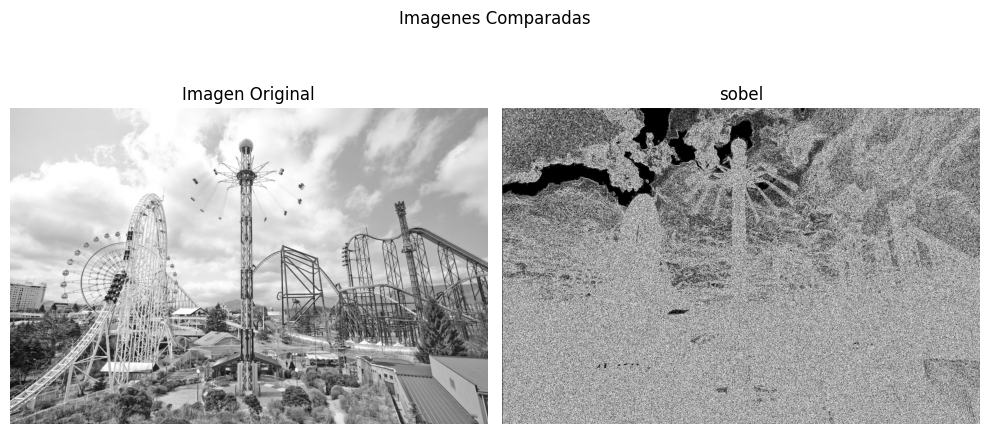

In [40]:
def sobel(imagen):
  sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=float)

  sobel_y = np.array([[-1, -2, -1],
                      [ 0,  0,  0],
                      [ 1,  2,  1]], dtype=float)

  gradiente_x = convolucion(imagen, sobel_x)
  gradiente_y = convolucion(imagen, sobel_y)

  sobel_imagen_salida = np.sqrt(gradiente_x**2 + gradiente_y**2)

  mostrar_imagenes(imagen,sobel_imagen_salida,"sobel")

  return(sobel_imagen_salida)

sobel_imagen_parque_salida = sobel(imagen_parque_areglo)

### Aplicar Laplacian

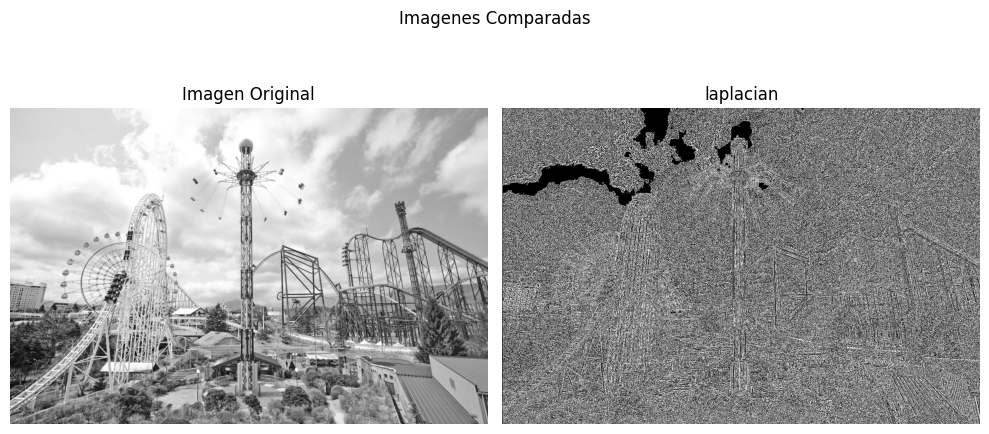

In [41]:
def laplacian(imagen):
  laplacian_kernel = np.array([[ 0,  1,  0],
                                [ 1, -4,  1],
                                [ 0,  1,  0]], dtype=float)

  laplacian_imagen_salida = convolucion(imagen, laplacian_kernel)

  mostrar_imagenes(imagen,laplacian_imagen_salida,"laplacian")

  return(laplacian_imagen_salida)

laplacian_imagen_parque_salida = laplacian(imagen_parque_areglo)

Complejidad Algorítmica y Eficiencia: la operación principal de los tres detectores es la convolución. Para una imagen de M×N píxeles y un kernel de K×L píxeles, la complejidad algorítmica de una sola convolución es de O(M×N×K×L).

**Prewitt y Sobel:** Estos detectores requieren dos operaciones de convolución (una para el eje X y otra para el eje Y), más una operación final para combinar los resultados (suma de cuadrados y raíz cuadrada). Como los kernels son de tamaño fijo (típicamente 3x3), podemos simplificar la complejidad a O(M×N) por cada convolución, por lo que la complejidad total es O(2×M×N) o, simplemente, O(M×N). La diferencia entre ambos radica en la sensibilidad al ruido: Prewitt asigna el mismo peso a todos los vecinos, mientras que Sobel da mayor peso al centro, lo que lo hace más robusto en condiciones reales de iluminación o ruido.

**Laplaciano:** Este detector solo requiere una operación de convolución con un único kernel. Su complejidad es, por lo tanto, O(M×N). Existen dos variantes comunes: con centro positivo (+4 u +8) o con centro negativo (–4 o –8), lo que invierte la polaridad del resultado pero no cambia la eficiencia. En este ejemplo, podemos observar cómo al usar +4 los bordes y formas se notan con mayor claridad.

Aunque la complejidad Big O es la misma para los tres (O(M×N)), la diferencia radica en el número de operaciones reales. El Laplaciano es más eficiente porque solo necesita una única convolución, mientras que Prewitt y Sobel necesitan dos. Esto significa que, en la práctica, el Laplaciano ejecuta la mitad de las multiplicaciones y sumas que Prewitt o Sobel.

**Comparación práctica:** desde el punto de vista de eficiencia de cálculo, el Laplaciano es el más rápido de los tres. Sin embargo, su desempeño en la detección de bordes puede variar dependiendo de la imagen, ya que al ser un operador de segundo orden es más sensible al ruido. Prewitt puede ser suficiente en imágenes sintéticas o de bajo ruido, mientras que Sobel es el preferido en aplicaciones reales por su mayor robustez.

<a name="realce"></a>

## 2.- Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

Utilizaremos la imagen procesada por el filtro laplaciano ya que esa imagen es de deteccion de bordes y sirve como mascara

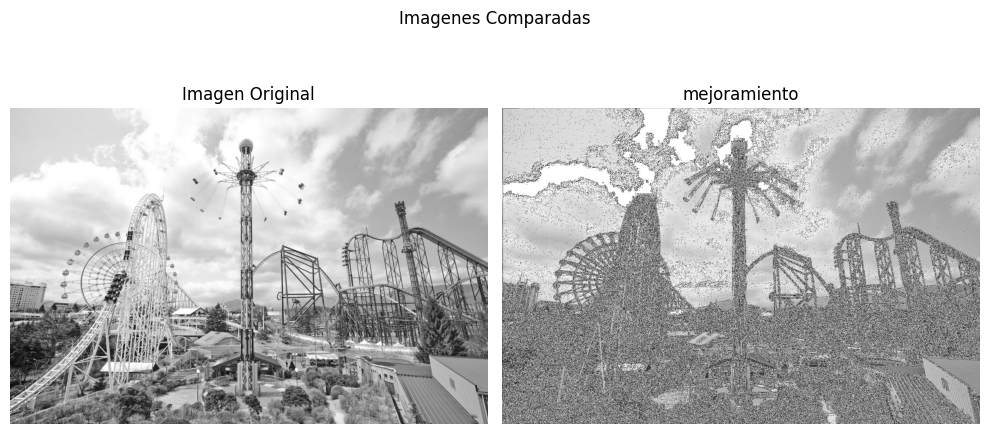

In [42]:
def mejorar_imagen(imagen,imagen_laplacian, alpha=1.5):
  # Multiplicamos la mascara por factor alpha
  mascara_multiplicada = alpha * imagen_laplacian
  # Aplicamos la mascara a la imagen
  imagen_mejorada = imagen + mascara_multiplicada
  # recortamos factores mayores a 255 para asegurar que no hayaun overflow
  #imagen_mejorada_clipped = np.clip(imagen_mejorada, 0, 255)


  mostrar_imagenes(imagen,imagen_mejorada,"mejoramiento")

  return imagen_mejorada

imagen_parque_mejorada = mejorar_imagen(imagen_parque_areglo,laplacian_imagen_parque_salida,3)

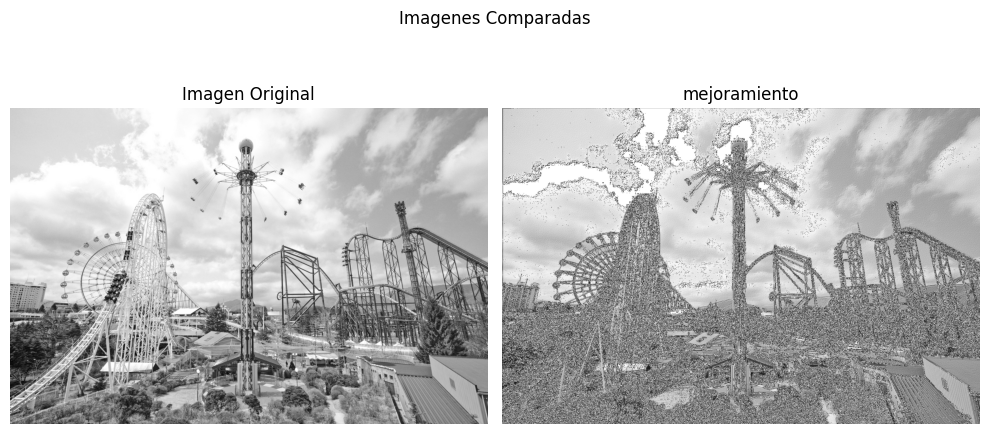

In [43]:
imagen_parque_mejorada = mejorar_imagen(imagen_parque_areglo,laplacian_imagen_parque_salida,2)

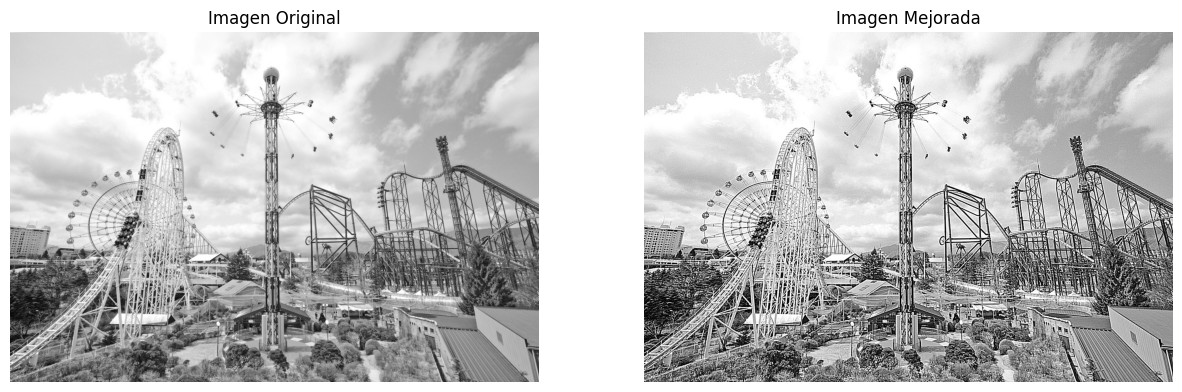

In [44]:
#----Ejercicio con cv2----

import cv2

def mejorar_imagen_2(imagen_uint8, alpha=1.5):
    # 1) convertir a float
    img = imagen_uint8.astype(np.float32)

    # 2) suavizado previo opcional
    img_blur = cv2.GaussianBlur(img, (3,3), 0)

    # 3) Laplaciano (centro positivo)
    lap = cv2.Laplacian(img_blur, ddepth=cv2.CV_32F, ksize=3)

    # 4) Normalización
    m = np.max(np.abs(lap)) + 1e-6
    lap_n = lap / m

    # 5) Diferencia con signo correcto para centro positivo
    enhanced = img - alpha * lap_n * 255.0

    # 6) Clip y regreso a uint8
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    return enhanced

# --- Ejemplo de uso ---
imagen_mejorada = mejorar_imagen_2(imagen_parque_areglo, alpha=1.5)

# Mostrar resultados
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("Imagen Original")
plt.imshow(imagen_parque_areglo, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Imagen Mejorada")
plt.imshow(imagen_mejorada, cmap="gray")
plt.axis("off")

plt.show()



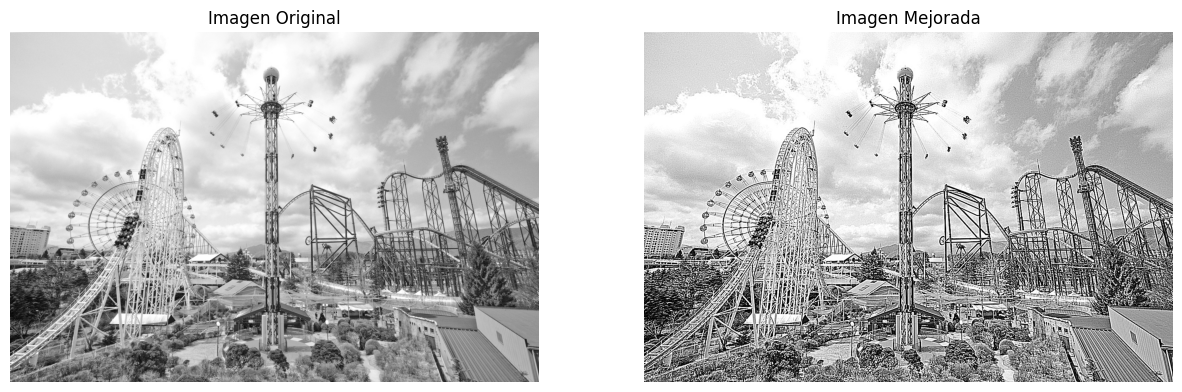

In [45]:
imagen_mejorada = mejorar_imagen_2(imagen_parque_areglo, alpha=3)
# Mostrar resultados
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("Imagen Original")
plt.imshow(imagen_parque_areglo, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Imagen Mejorada")
plt.imshow(imagen_mejorada, cmap="gray")
plt.axis("off")

plt.show()

<a name="medica"></a>

## 3.- Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes

### Aplicar Laplacian

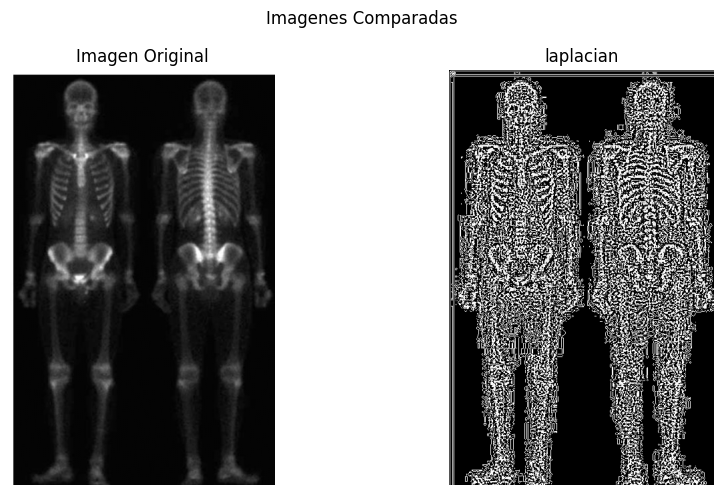

In [46]:
laplacian_imagen_pet = laplacian(imagen_pet_areglo)

### Mejorar imagen

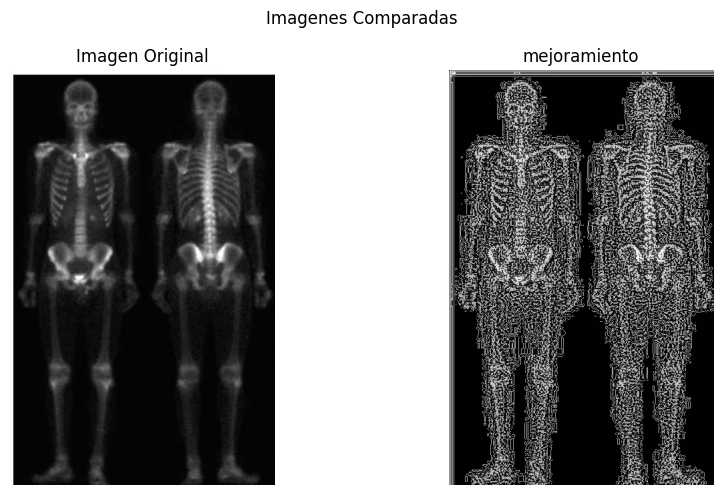

In [47]:
pet_imagen_laplacian_mejorada = mejorar_imagen(imagen_pet_areglo,laplacian_imagen_pet)
pet_imagen_laplacian_mejorada_normalizada = pet_imagen_laplacian_mejorada.astype(float) / 255.0


### Aplicar Sobel

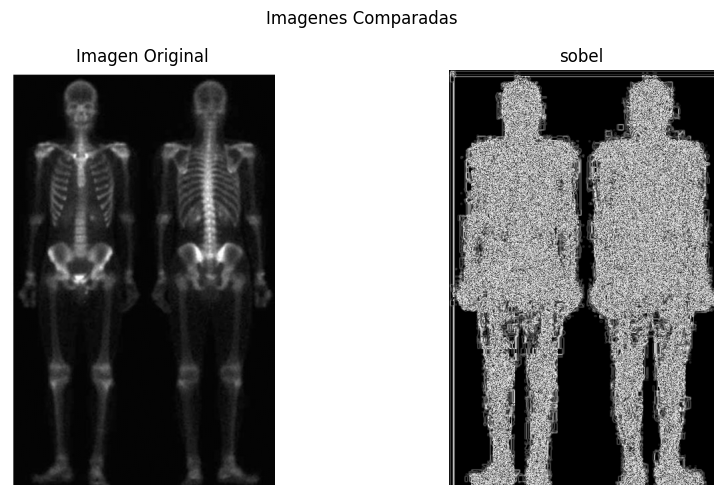

In [48]:
sobel_imagen_pet = sobel(imagen_pet_areglo)

### Smooth Sobel

In [49]:
def smooth_image(imagen, dim_filtro=5):
    """
    Suaviza una imagen usando un filtro de promedio.
    """
    kernel = np.ones((dim_filtro, dim_filtro), dtype=float) / (dim_filtro**2)
    imagen_smooth = convolucion(imagen, kernel)
    mostrar_imagenes(imagen,imagen_smooth, "smooth sobel")

    return imagen_smooth


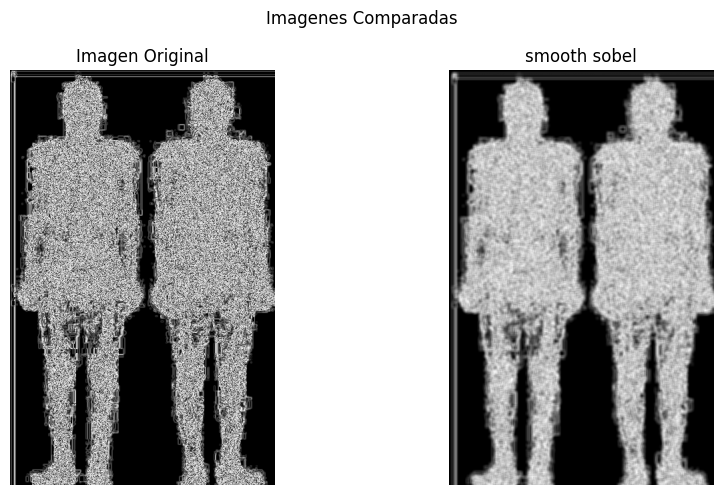

In [50]:
sobel_smooth_imagen_pet = smooth_image(sobel_imagen_pet)
sobel_smooth_imagen_pet_normalizada = sobel_smooth_imagen_pet.astype(float) / 255.0

### Multiplicar smooth Sobel con laplacian

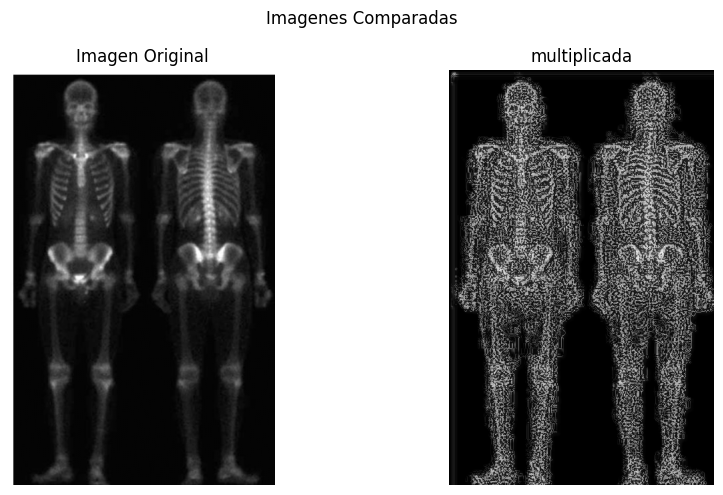

In [51]:
pet_imagen_laplacian_mejorada_float = pet_imagen_laplacian_mejorada.astype(float)
multiplicada = pet_imagen_laplacian_mejorada_normalizada * sobel_smooth_imagen_pet_normalizada
mostrar_imagenes(imagen_pet_areglo,multiplicada,"multiplicada")

### Mejorar imagen original con multiplicada

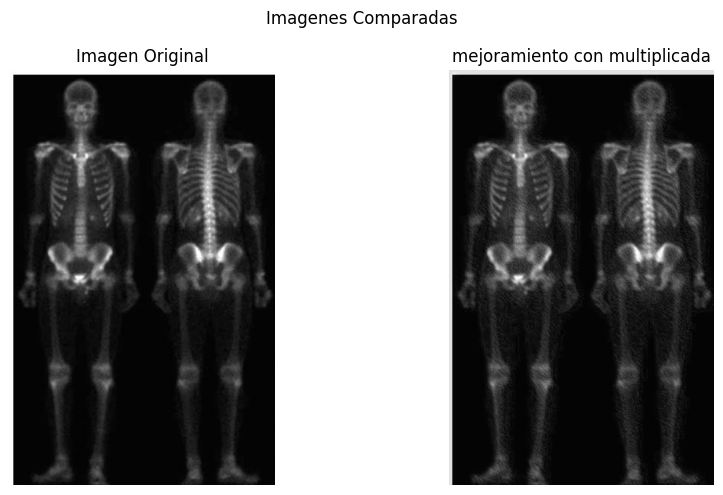

In [52]:
imagen_paso_g = imagen_pet_areglo + multiplicada * 255
mostrar_imagenes(imagen_pet_areglo,imagen_paso_g,"mejoramiento con multiplicada")


### Aplicar power transform

In [53]:
def power_law_transform(imagen, gamma=1.0):
    """
    Aplica una transformación de ley de potencia (corrección gamma).
    """
    imagen_float = imagen.astype(float) / 255.0
    imagen_transformada = imagen_float**gamma
    return (imagen_transformada * 255).astype(np.uint8)

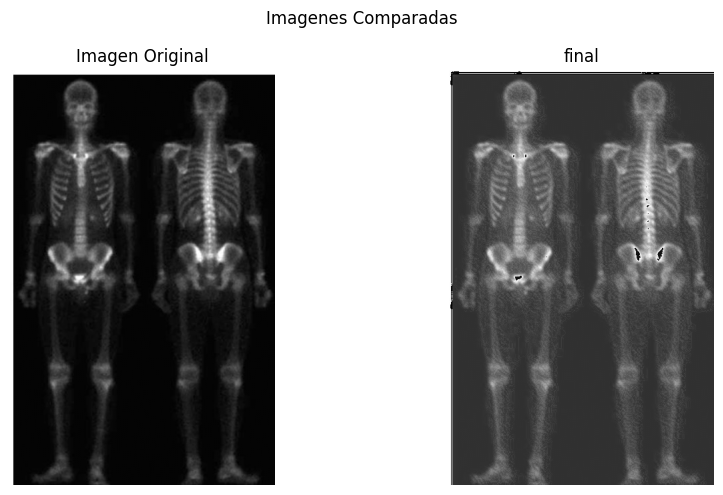

In [54]:
imagen_final = power_law_transform(imagen_paso_g, gamma=1)

mostrar_imagenes(imagen_pet_areglo,imagen_final,"final")

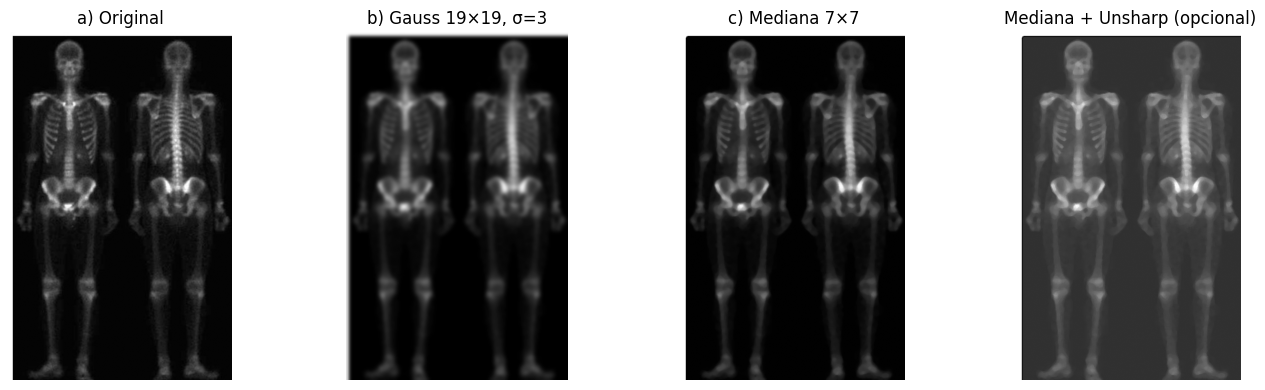

True

In [55]:
#----Ejercicio con cv2----

# --- ruta de la radiografía ---
PATH = "/content/drive/MyDrive/Equipo 48/Imagenes Convolucion/PET2_libro.jpg"

# --- cargar en escala de grises ---
img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
assert img is not None, f"No se pudo leer la imagen en: {PATH}"

# --- (b) Filtro Gaussiano 19x19, sigma=3 ---
gauss = cv2.GaussianBlur(img, (19, 19), 3)

# --- (c) Filtro de Mediana 7x7 (robusto a sal-y-pimienta) ---
med = cv2.medianBlur(img, 7)

# --- (opcional) Realce suave posterior: Unsharp Mask sobre la mediana ---
amount = 1.0          # 0.3–1.5 típico
sigma_sharp = 1.2     # sigma del blur interno del unsharp
blur_med = cv2.GaussianBlur(med, (0, 0), sigma_sharp)
sharpen_med = cv2.addWeighted(med, 1 + amount, blur_med, -amount, 0)

# --- mostrar resultados ---
plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.title("a) Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,4,2); plt.title("b) Gauss 19×19, σ=3"); plt.imshow(gauss, cmap="gray"); plt.axis("off")
plt.subplot(1,4,3); plt.title("c) Mediana 7×7"); plt.imshow(med, cmap="gray"); plt.axis("off")
plt.subplot(1,4,4); plt.title("Mediana + Unsharp (opcional)"); plt.imshow(sharpen_med, cmap="gray"); plt.axis("off")
plt.tight_layout()
plt.show()

# --- (opcional) guardar resultados junto a la imagen original ---
out_dir = os.path.dirname(PATH)
cv2.imwrite(os.path.join(out_dir, "PET_gauss_19x19_sigma3.png"), gauss)
cv2.imwrite(os.path.join(out_dir, "PET_mediana_7x7.png"), med)
cv2.imwrite(os.path.join(out_dir, "PET_mediana_unsharp.png"), sharpen_med)

# Referencias

Gonzalez, R. C., & Woods, R. E. (2018). Digital image processing (4th ed.). Pearson.

3Blue1Brown. (2022, November 18). But what is a convolution? [Video]. YouTube. https://www.youtube.com/watch?v=KuXjwB4LzSA

Team, L., & Team, L. (2024, February 5). Image filtering using Convolution in OpenCV | LearnOpenCV #. LearnOpenCV – Learn OpenCV, PyTorch, Keras, Tensorflow With Code, & Tutorials. https://learnopencv.com/image-filtering-using-convolution-in-opencv/

LearnOpenCV. (2024, January 29). Image Filtering with Convolution in OpenCV [Video]. YouTube. https://www.youtube.com/watch?v=o0KDTwa0cR0